# Gross-Pitaevskii equation in one dimension
In this example we will use DFTK to solve
the Gross-Pitaevskii equation, and use this opportunity to explore a few internals.

## The model
The [Gross-Pitaevskii equation](https://en.wikipedia.org/wiki/Gross%E2%80%93Pitaevskii_equation) (GPE)
is a simple non-linear equation used to model bosonic systems
in a mean-field approach. Denoting by $ψ$ the effective one-particle bosonic
wave function, the time-independent GPE reads in atomic units:
$$
    H ψ = \left(-\frac12 Δ + V + 2 C |ψ|^2\right) ψ = μ ψ \qquad \|ψ\|_{L^2} = 1
$$
where $C$ provides the strength of the boson-boson coupling.
It's in particular a favorite model of applied mathematicians because it
has a structure simpler than but similar to that of DFT, and displays
interesting behavior (especially in higher dimensions with magnetic fields, see
Gross-Pitaevskii equation with external magnetic field).

We wish to model this equation in 1D using DFTK.
First we set up the lattice. For a 1D case we supply two zero lattice vectors,

In [1]:
a = 10
lattice = a .* [[1 0 0.]; [0 0 0]; [0 0 0]];

which is special cased in DFTK to support 1D models.

For the potential term `V` we pick a harmonic
potential. We use the function `ExternalFromReal` which uses
Cartesian coordinates ( see Lattices and lattice vectors).

In [2]:
pot(x) = (x - a/2)^2;

We setup each energy term in sequence: kinetic, potential and nonlinear term.
For the non-linearity we use the `LocalNonlinearity(f)` term of DFTK, with f(ρ) = C ρ^α.
This object introduces an energy term $C ∫ ρ(r)^α dr$
to the total energy functional, thus a potential term $α C ρ^{α-1}$.
In our case we thus need the parameters

In [3]:
C = 1.0
α = 2;

… and with this build the model

In [4]:
using DFTK
using LinearAlgebra

n_electrons = 1  # Increase this for fun
terms = [Kinetic(),
         ExternalFromReal(r -> pot(r[1])),
         LocalNonlinearity(ρ -> C * ρ^α),
]
model = Model(lattice; n_electrons, terms, spin_polarization=:spinless);  # spinless electrons

We discretize using a moderate Ecut (For 1D values up to `5000` are completely fine)
and run a direct minimization algorithm:

In [5]:
basis = PlaneWaveBasis(model, Ecut=500, kgrid=(1, 1, 1))
scfres = direct_minimization(basis, tol=1e-8) # This is a constrained preconditioned LBFGS
scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Δtime
---   ---------------   ---------   ---------   ------
  1   +164.7434055814                   -1.56    325ms
  2   +125.1129982953        1.60       -0.87   1.66ms
  3   +78.48500503991        1.67       -0.64   1.67ms
  4   +15.90732617632        1.80       -0.45   22.3ms
  5   +8.286818172660        0.88       -0.43   1.37ms
  6   +7.392898173633       -0.05       -0.38    968μs
  7   +4.814696613169        0.41       -0.22    907μs
  8   +3.476832421799        0.13       -0.17    910μs
  9   +2.228350825263        0.10       -0.23    898μs
 10   +1.950738652714       -0.56       -0.39    742μs
 11   +1.525491610343       -0.37       -0.31    895μs
 12   +1.308002394925       -0.66       -0.70    719μs
 13   +1.197606408986       -0.96       -0.82    702μs
 14   +1.168938767778       -1.54       -0.88    706μs
 15   +1.152991350915       -1.80       -1.39    704μs
 16   +1.148229740134       -2.32       -1.64    729μs
 17   +1.14

Energy breakdown (in Ha):
    Kinetic             0.2682057 
    ExternalFromReal    0.4707475 
    LocalNonlinearity   0.4050836 

    total               1.144036852755 

## Internals
We use the opportunity to explore some of DFTK internals.

Extract the converged density and the obtained wave function:

In [6]:
ρ = real(scfres.ρ)[:, 1, 1, 1]  # converged density, first spin component
ψ_fourier = scfres.ψ[1][:, 1];    # first k-point, all G components, first eigenvector

Transform the wave function to real space and fix the phase:

In [7]:
ψ = ifft(basis, basis.kpoints[1], ψ_fourier)[:, 1, 1]
ψ /= (ψ[div(end, 2)] / abs(ψ[div(end, 2)]));

Check whether $ψ$ is normalised:

In [8]:
x = a * vec(first.(DFTK.r_vectors(basis)))
N = length(x)
dx = a / N  # real-space grid spacing
@assert sum(abs2.(ψ)) * dx ≈ 1.0

The density is simply built from ψ:

In [9]:
norm(scfres.ρ - abs2.(ψ))

8.175653374407583e-16

We summarize the ground state in a nice plot:

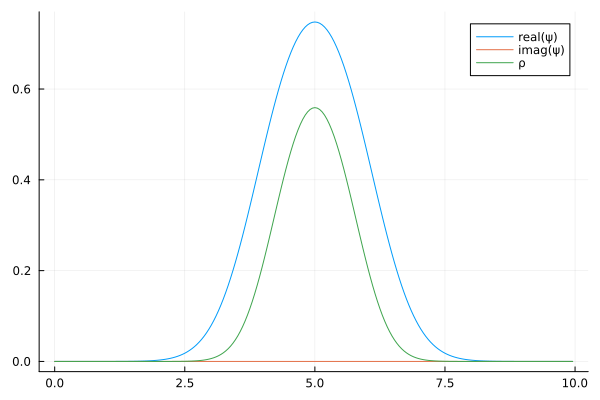

In [10]:
using Plots

p = plot(x, real.(ψ), label="real(ψ)")
plot!(p, x, imag.(ψ), label="imag(ψ)")
plot!(p, x, ρ, label="ρ")

The `energy_hamiltonian` function can be used to get the energy and
effective Hamiltonian (derivative of the energy with respect to the density matrix)
of a particular state (ψ, occupation).
The density ρ associated to this state is precomputed
and passed to the routine as an optimization.

In [11]:
E, ham = energy_hamiltonian(basis, scfres.ψ, scfres.occupation; ρ=scfres.ρ)
@assert E.total == scfres.energies.total

Now the Hamiltonian contains all the blocks corresponding to $k$-points. Here, we just
have one $k$-point:

In [12]:
H = ham.blocks[1];

`H` can be used as a linear operator (efficiently using FFTs), or converted to a dense matrix:

In [13]:
ψ11 = scfres.ψ[1][:, 1] # first k-point, first eigenvector
Hmat = Array(H)  # This is now just a plain Julia matrix,
#                  which we can compute and store in this simple 1D example
@assert norm(Hmat * ψ11 - H * ψ11) < 1e-10

Let's check that ψ11 is indeed an eigenstate:

In [14]:
norm(H * ψ11 - dot(ψ11, H * ψ11) * ψ11)

1.9327652737610915e-7

Build a finite-differences version of the GPE operator $H$, as a sanity check:

In [15]:
A = Array(Tridiagonal(-ones(N - 1), 2ones(N), -ones(N - 1)))
A[1, end] = A[end, 1] = -1
K = A / dx^2 / 2
V = Diagonal(pot.(x) + C .* α .* (ρ.^(α-1)))
H_findiff = K + V;
maximum(abs.(H_findiff*ψ - (dot(ψ, H_findiff*ψ) / dot(ψ, ψ)) * ψ))

0.00022341490873031218